In [1]:
#import libraries
import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#for reproducibility
torch.manual_seed(42)
np.random.seed(42)

#create data with positive instances (X2, Y2) and negative (X1, Y1)
#[N, T, F] number of instances (samples), time, features
#NB: this could represent time series data OR sequence data (audio, sensor readings,...)
X1 = torch.randn(500, 5000, 100)
X2 = torch.randn(500, 5000, 100) + 1.5
X = torch.cat([X1, X2], dim=0)      #X=[1000, 5000, 100] 1000 samples

Y1 = torch.zeros(500, 1)
Y2 = torch.ones(500, 1)
Y = torch.cat([Y1, Y2], dim=0)      #Y=[1000, 1] 1000 labels 0 and 1

#[N, F] instances, time, features
print(X.size())
#[N, 1] instances, label [0,1]
print(Y.size())

torch.Size([1000, 5000, 100])
torch.Size([1000, 1])


In [2]:
#define model
class Net(nn.Module):

    def __init__(self, feat_size=100, hidden_size=100, num_labels=1, dropout=0.2, bidirectional=False, feat_representation='mean'):
        super().__init__()
        self.feat_representation = feat_representation
        self.bidirectional = bidirectional
        self.fc1 = nn.Linear(feat_size, feat_size)      #linear layer to process input feat before LSTM
        self.relu = nn.ReLU()       #activation
        self.dout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(feat_size, hidden_size, batch_first=True,       #core seq model (LSTM); handles seqs of shape [B, T, F]
                            bidirectional=bidirectional)
        encoding_size = hidden_size * 2 if bidirectional else hidden_size
        self.fc2 = nn.Linear(encoding_size, hidden_size)
        self.out = nn.Linear(hidden_size, num_labels)
        self.out_act = nn.Sigmoid()     #squash output to [0,1] --> probability

    def forward(self, x):
        #[B, T, F] batch, time, features
        h1 = self.fc1(x)        #linear layer
        h1 = self.relu(h1)      #relu activation
        #[B, T, H] batch, time, hidden or hidden * 2
        outputs, (final, _) = self.lstm(h1)   #mke gru!!

        if self.feat_representation == 'mean':
            #mean over hidden states of LSTM
            outputs = self.dout(outputs)
            h = self.relu(self.fc2(outputs))
            #[B, H]
            h = h.mean(dim=1)
        elif self.feat_representation == 'last_state':
            #last hidden state of the lstm or concat of bidirectional forward and backward states
            if self.bidirectional:
                h_T_fwd = final[0]
                h_T_bwd = final[1]
                h = torch.cat([h_T_fwd, h_T_bwd], dim=-1)
            else:
                h = final[-1]
            h = self.relu(self.fc2(h))
            h = self.dout(h)
        #[B, 1]
        logits = self.out(h)        #raw scores before3 activation
        probs = self.out_act(logits)    #sigmoid probabilities
        return logits, probs

In [3]:
#training setup
#model
model = Net()
#check for device
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)

#print architecture
print(model)

#define adam optimizer
opt = optim.Adam(model.parameters(), lr=1e-3)
#define binary loss
criterion = nn.BCEWithLogitsLoss()

Net(
  (fc1): Linear(in_features=100, out_features=100, bias=True)
  (relu): ReLU()
  (dout): Dropout(p=0.2, inplace=False)
  (lstm): LSTM(100, 100, batch_first=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (out): Linear(in_features=100, out_features=1, bias=True)
  (out_act): Sigmoid()
)


In [4]:
#define hyperparameters
e_losses = []       #collect and store loss values
num_epochs = 20     #20 total passes
batch_size = 64     #64 seqs at once

Text(0.5, 1.0, 'Training Loss for Net')

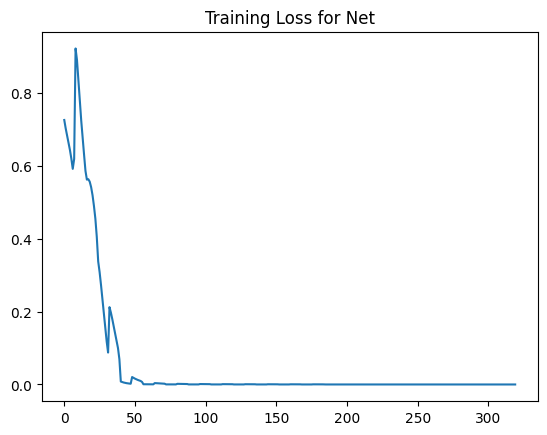

In [5]:
#training loop
for e in range(num_epochs):
    model.train()
    loss_batch = []

    for beg_i in range(0, X.size(0), batch_size):       #go over data in steps of batch_size (beg_i=starting index)
        #batch instances given batch size
        x_batch = X[beg_i:beg_i + batch_size, :]        #slice batch of X (samples)
        y_batch = Y[beg_i:beg_i + batch_size, :]        #slice batch of Y (labels)
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        opt.zero_grad()     #clear gradients of all model parameters before next backpropagation

        #(1) Forward
        y_logits, y_probs = model(x_batch)
        #print(y_probs.size())
        #y_logits=raw output before sigmoid
        #y_probs=after sigmoid activation (values between 0 and 1)

        #(2) Compute loss
        loss = criterion(y_logits, y_batch)     #compare predictions y_logits to true labels y_batch (binary CE)
        #save loss of batch
        loss_batch.append(loss.item())

        #(3) Compute gradients
        loss.backward()
        #print('backprop')

        #(4) update weights
        opt.step()

    e_losses += loss_batch

#plot loss over epochs (tracks batch-level losses; NOT epoch-averaged)
plt.plot(e_losses)
plt.title('Training Loss for Net')

In [6]:
#set model to evaluation mode and get predictions
model.eval()

#prediction
x_t = torch.randn(1, 5000, 100)     #create test sample (batch size=1)
x_t = x_t.to(device)
y_logit, y_prob = model(x_t)        #curve centered at 0 (--> label 0)
print(y_prob.item())

x_1_t = torch.randn(1, 5000, 100) + 1.5     #create test sample but shifted (batch size=1)
x_1_t = x_1_t.to(device)
y1_logit, y1_prob = model(x_1_t)    #curve centered at 1.5 (--> label 1)
print(y1_prob.item())

0.00014710359391756356
0.9999673366546631


# TODO

Make a new section for each new model NetLast(), NetBiLSTM(), NetDropout()....

- Try different feature representations: last state and bidirectional LSTM
- try different feature sizes, and dropout [0.1, 0.5, 0.8]
- try different non linearities: sigmod, tanh
- Use a GRU instead of LSTM: [GRU pytorch](https://pytorch.org/docs/stable/generated/torch.nn.GRU.html)
- what if we predict a sequence instead of classification?
```python
#[N, T, F] number of instances, time, features
X1 = torch.randn(1000, 48, 50)
X2 = torch.randn(1000, 48, 50) + 1.5
X = torch.cat([X1, X2], dim=0)
mask = torch.cuda.FloatTensor(2000, 48, 1).uniform_() > 0.8
Y1 = torch.zeros(1000, 1)
Y2 = torch.ones(1000, 1)
#[B, 1]
Y_mean = torch.cat([Y1, Y2], dim=0)
#[B, T, 1]
Y_seq = Y_mean.unsqueeze(1).repeat(1, 48, 1)
#[N, F] instances, time, features
print(X.size())
#[N, 1] instances, label [0,1]
print(Y_seq.size())
#print(Y_mean.size())
print(mask.size())
#in model
def forward(self, x):
    #...
    #[B, T, H]
    #h_mean = h_time.mean(1)
    #[B, T, H] logits is a seq
    #logits_mean = self.out_mean(h_mean)
    return logits_seq
#criterion
criterion = nn.BCEWithLogitsLoss(reduction='none')
#[B, 1] mean (0)
#loss
#[B, T, 1]
loss_seq = loss_seq * x_mask
loss_seq = loss_seq.sum(1)
loss_seq = loss_seq.mean(0)
```
- change BCElogits to probs https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html


In [7]:
def train_model(model_class, model_name, X, Y, device='cpu', num_epochs=20, batch_size=64, lr=1e-3):
    #1. initialize and move to device
    model = model_class()
    model = model.to(device)

    #2. print architecture
    print(f"=== Architecture for {model_name} ===")
    print(model)

    #3. define optimizer and loss
    opt = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()

    #4. training loop
    e_losses = []

    for e in range(num_epochs):
        model.train()
        loss_batch = []

        for beg_i in range(0, X.size(0), batch_size):
            x_batch = X[beg_i:beg_i + batch_size, :]
            y_batch = Y[beg_i:beg_i + batch_size, :]
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            opt.zero_grad()

            y_logits, y_probs = model(x_batch)

            loss = criterion(y_logits, y_batch)
            loss_batch.append(loss.item())

            loss.backward()

            opt.step()

        e_losses += loss_batch

    #5. plot loss over epochs
    plt.plot(e_losses)
    plt.title(f'Training Loss for {model_name}')

    return model

In [8]:
def evaluate_model(model, device='cpu'):
    model.eval()

    with torch.no_grad():

        #for reproducibility
        torch.manual_seed(42)

        #test on random sample (expected label 0)
        x_t = torch.randn(1, 5000, 100).to(device)
        y_logit, y_prob = model(x_t)
        print(f"Random sample (close 0): {y_prob.item():.4f}")

        #test on shifted sample (expected label 1)
        x_1_t = torch.randn(1, 5000, 100).to(device) + 1.5
        y1_logit, y1_prob = model(x_1_t)
        print(f"Shifted sample (close 1): {y1_prob.item():.4f}")

    return y_prob.item(), y1_prob.item()

# NetLast()

In [9]:
# === Model 1: NetLast (use last hidden state) ===
class NetLast(Net):
    def __init__(self):
        super().__init__(feat_representation='last_state')

=== Architecture for NetLast ===
NetLast(
  (fc1): Linear(in_features=100, out_features=100, bias=True)
  (relu): ReLU()
  (dout): Dropout(p=0.2, inplace=False)
  (lstm): LSTM(100, 100, batch_first=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (out): Linear(in_features=100, out_features=1, bias=True)
  (out_act): Sigmoid()
)


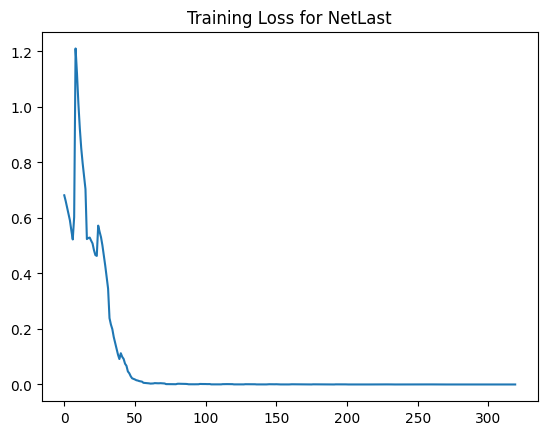

In [10]:
# === Train NetLast ===
model_netlast = train_model(NetLast, 'NetLast', X, Y, device=device, num_epochs=20, batch_size=64, lr=1e-3)

In [11]:
# === Evaluate NetLast ===
evaluate_model(model_netlast, device=device)

Random sample (close 0): 0.0001
Shifted sample (close 1): 1.0000


(0.00014909429592080414, 0.9999796152114868)

# NetBiLSTM()

In [12]:
# === Model 2: NetBiLSTM (bidirectional LSTM) ===
class NetBiLSTM(Net):
    def __init__(self):
        super().__init__(bidirectional=True)

=== Architecture for NetBiLSTM ===
NetBiLSTM(
  (fc1): Linear(in_features=100, out_features=100, bias=True)
  (relu): ReLU()
  (dout): Dropout(p=0.2, inplace=False)
  (lstm): LSTM(100, 100, batch_first=True, bidirectional=True)
  (fc2): Linear(in_features=200, out_features=100, bias=True)
  (out): Linear(in_features=100, out_features=1, bias=True)
  (out_act): Sigmoid()
)


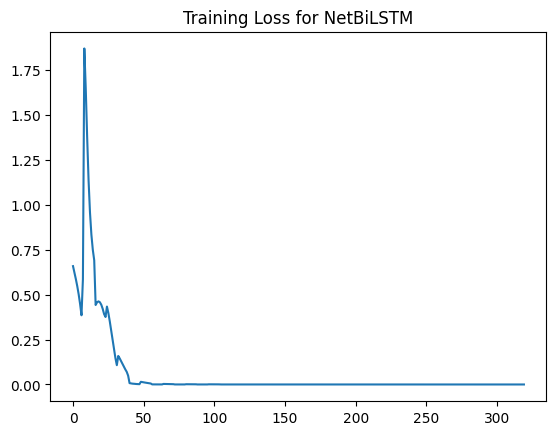

In [13]:
# === Train NetBiLSTM ===
model_netbilstm = train_model(NetBiLSTM, 'NetBiLSTM', X, Y, device=device, num_epochs=20, batch_size=64, lr=1e-3)

In [14]:
# === Evaluate NetBiLSTM ===
evaluate_model(model_netbilstm, device=device)

Random sample (close 0): 0.0001
Shifted sample (close 1): 0.9999


(0.0001419662294210866, 0.9999412298202515)

# NetDropout()

In [15]:
# === Model 3a: NetDropout01 (Dropout 0.1) ===
class NetDropout01(Net):
    def __init__(self):
        super().__init__(dropout=0.1)

# === Model 3b: NetDropout05 (Dropout 0.5) ===
class NetDropout05(Net):
    def __init__(self):
        super().__init__(dropout=0.5)

# === Model 3c: NetDropout08 (Dropout 0.8) ===
class NetDropout08(Net):
    def __init__(self):
        super().__init__(dropout=0.8)

=== Architecture for NetDropout01 ===
NetDropout01(
  (fc1): Linear(in_features=100, out_features=100, bias=True)
  (relu): ReLU()
  (dout): Dropout(p=0.1, inplace=False)
  (lstm): LSTM(100, 100, batch_first=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (out): Linear(in_features=100, out_features=1, bias=True)
  (out_act): Sigmoid()
)


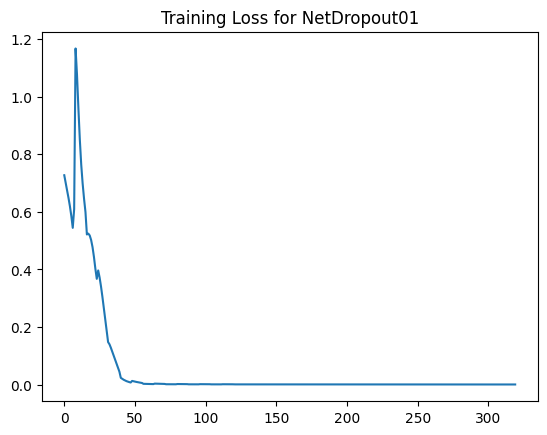

In [16]:
# === Train NetDropout01 ===
model_netdropout01 = train_model(NetDropout01, 'NetDropout01', X, Y, device=device, num_epochs=20, batch_size=64, lr=1e-3)

In [17]:
# === Evaluate NetDropout01 ===
evaluate_model(model_netdropout01, device=device)

Random sample (close 0): 0.0001
Shifted sample (close 1): 0.9999


(0.00010507318074814975, 0.9999032020568848)

=== Architecture for NetDropout05 ===
NetDropout05(
  (fc1): Linear(in_features=100, out_features=100, bias=True)
  (relu): ReLU()
  (dout): Dropout(p=0.5, inplace=False)
  (lstm): LSTM(100, 100, batch_first=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (out): Linear(in_features=100, out_features=1, bias=True)
  (out_act): Sigmoid()
)


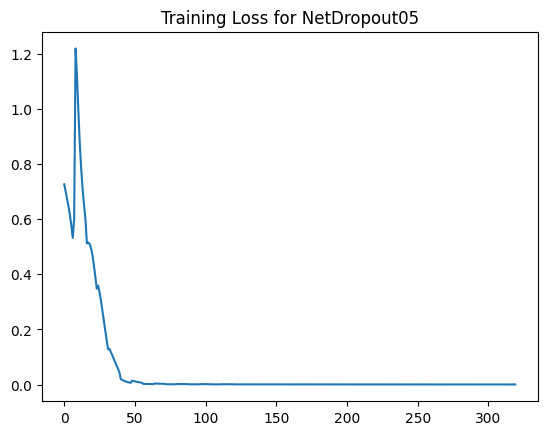

In [18]:
# === Train NetDropout05 ===
model_netdropout05 = train_model(NetDropout05, 'NetDropout05', X, Y, device=device, num_epochs=20, batch_size=64, lr=1e-3)

In [19]:
# === Evaluate NetDropout05 ===
evaluate_model(model_netdropout05, device=device)

Random sample (close 0): 0.0002
Shifted sample (close 1): 0.9999


(0.00018014218949247152, 0.9998780488967896)

=== Architecture for NetDropout08 ===
NetDropout08(
  (fc1): Linear(in_features=100, out_features=100, bias=True)
  (relu): ReLU()
  (dout): Dropout(p=0.8, inplace=False)
  (lstm): LSTM(100, 100, batch_first=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (out): Linear(in_features=100, out_features=1, bias=True)
  (out_act): Sigmoid()
)


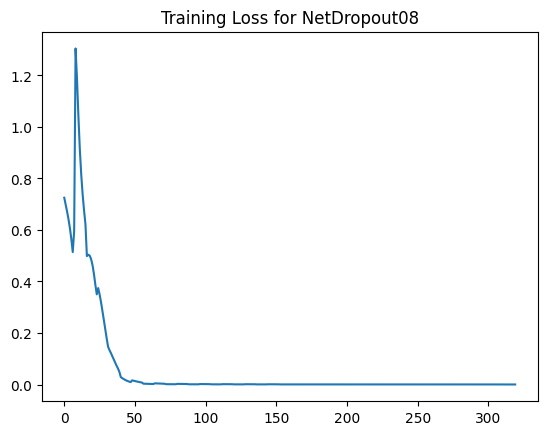

In [20]:
# === Train NetDropout08 ===
model_netdropout08 = train_model(NetDropout08, 'NetDropout08', X, Y, device=device, num_epochs=20, batch_size=64, lr=1e-3)

In [21]:
# === Evaluate NetDropout08 ===
evaluate_model(model_netdropout08, device=device)

Random sample (close 0): 0.0003
Shifted sample (close 1): 0.9999


(0.0002534403756726533, 0.9998593330383301)

# NetSigmoid()

In [22]:
# === Model 4: NetSigmoid (different non-linearity activation function) ===
class NetSigmoid(Net):
    def __init__(self):
        super().__init__()
        self.relu = nn.Sigmoid()        #changing activation function Sigmoid()

=== Architecture for NetSigmoid ===
NetSigmoid(
  (fc1): Linear(in_features=100, out_features=100, bias=True)
  (relu): Sigmoid()
  (dout): Dropout(p=0.2, inplace=False)
  (lstm): LSTM(100, 100, batch_first=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (out): Linear(in_features=100, out_features=1, bias=True)
  (out_act): Sigmoid()
)


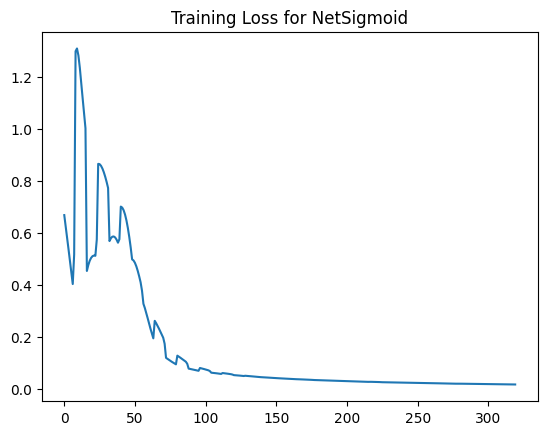

In [23]:
# === Train NetSigmoid ===
model_netsigmoid = train_model(NetSigmoid, 'NetSigmoid', X, Y, device=device, num_epochs=20, batch_size=64, lr=1e-3)

In [24]:
# === Evaluate NetSigmoid ===
evaluate_model(model_netsigmoid, device=device)

Random sample (close 0): 0.0154
Shifted sample (close 1): 0.9844


(0.015391825698316097, 0.9844194054603577)

# NetTanh()

In [25]:
# === Model 5: NetTanh (use Tanh activation instead of ReLU) ===
class NetTanh(Net):
    def __init__(self):
        super().__init__()
        self.relu = nn.Tanh()       #Tanh()

=== Architecture for NetTanh ===
NetTanh(
  (fc1): Linear(in_features=100, out_features=100, bias=True)
  (relu): Tanh()
  (dout): Dropout(p=0.2, inplace=False)
  (lstm): LSTM(100, 100, batch_first=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (out): Linear(in_features=100, out_features=1, bias=True)
  (out_act): Sigmoid()
)


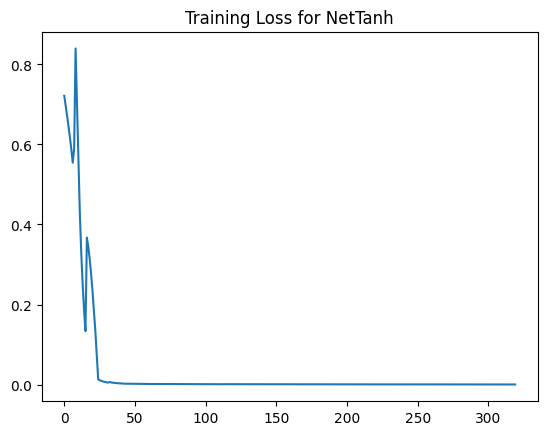

In [26]:
# === Train NetTanh ===
model_nettanh = train_model(NetTanh, 'NetTanh', X, Y, device=device, num_epochs=20, batch_size=64, lr=1e-3)

In [27]:
# === Evaluate NetTanh ===
evaluate_model(model_nettanh, device=device)

Random sample (close 0): 0.0003
Shifted sample (close 1): 0.9997


(0.0003424638125579804, 0.9996956586837769)

# NetGRU()

NB: (returns...)

LSTM	(output, (hidden, cell))

GRU	(output, hidden)

In [28]:
# === Model 6: NetGRU (use GRU instead of LSTM) ===
class NetGRU(Net):
    def __init__(self):
        super().__init__()
        self.lstm = nn.GRU(
            input_size=100,
            hidden_size=100,
            batch_first=True,
            bidirectional=self.bidirectional
        )

    def forward(self, x):       #overwrites forward() from Net
        h1 = self.fc1(x)
        h1 = self.relu(h1)
        outputs, final = self.lstm(h1)      #only outputs, final (no second value)

        if self.feat_representation == 'mean':
            outputs = self.dout(outputs)
            h = self.relu(self.fc2(outputs))
            h = h.mean(dim=1)
        elif self.feat_representation == 'last_state':
            if self.bidirectional:
                h_T_fwd = final[0]
                h_T_bwd = final[1]
                h = torch.cat([h_T_fwd, h_T_bwd], dim=-1)
            else:
                h = final[-1]
            h = self.relu(self.fc2(h))
            h = self.dout(h)

        logits = self.out(h)
        probs = self.out_act(logits)
        return logits, probs

=== Architecture for NetGRU ===
NetGRU(
  (fc1): Linear(in_features=100, out_features=100, bias=True)
  (relu): ReLU()
  (dout): Dropout(p=0.2, inplace=False)
  (lstm): GRU(100, 100, batch_first=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (out): Linear(in_features=100, out_features=1, bias=True)
  (out_act): Sigmoid()
)


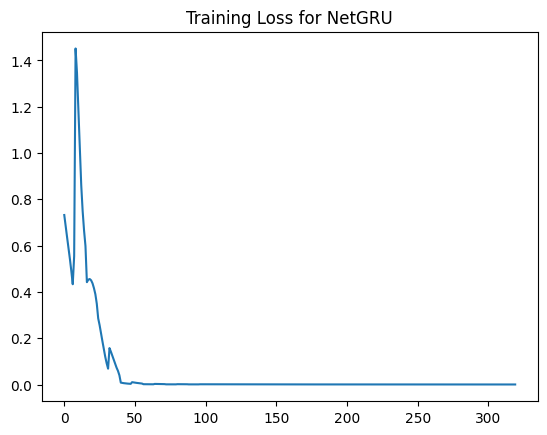

In [29]:
# === Train NetGRU ===
model_netgru = train_model(NetGRU, 'NetGRU', X, Y, device=device, num_epochs=20, batch_size=64, lr=1e-3)

In [30]:
# === Evaluate NetGRU ===
evaluate_model(model_netgru, device=device)

Random sample (close 0): 0.0001
Shifted sample (close 1): 0.9999


(0.00010129439033335075, 0.9998838901519775)

# NetSeqOut()

NB: predict a sequence of labels

In [31]:
torch.manual_seed(42)
np.random.seed(42)

#simulate new sequences: 2000 examples, 48 time steps, 50 features
X1 = torch.randn(1000, 48, 50)
X2 = torch.randn(1000, 48, 50) + 1.5
X = torch.cat([X1, X2], dim=0)      #X=[2000, 48, 50] 2000 samples

#create binary labels: 0 for first half, 1 for second half
Y1 = torch.zeros(1000, 1)
Y2 = torch.ones(1000, 1)
Y = torch.cat([Y1, Y2], dim=0)      #Y=[2000, 1] 2000 labels 0 and 1

#repeat label for every time step --> [B, T, 1]
Y_seq = Y.unsqueeze(1).repeat(1, 48, 1)

#create mask to simulate missing/irrelevant time steps
mask = (torch.rand(2000, 48, 1) > 0.2).float()      #80% keep, 20% masked

#shapes
print(X.shape)          #[2000, 48, 50]
print(Y_seq.shape)      #[2000, 48, 1]
print(mask.shape)       #[2000, 48, 1]

torch.Size([2000, 48, 50])
torch.Size([2000, 48, 1])
torch.Size([2000, 48, 1])


In [32]:
# === Model 7: NetSeqOut (predict sequence of labels instead of a single label) ===
class NetSeqOut(nn.Module):
    def __init__(self, feat_size=50, hidden_size=100, num_labels=1, dropout=0.2, bidirectional=False):
        super().__init__()
        self.lstm = nn.LSTM(feat_size, hidden_size, batch_first=True,
                            bidirectional=bidirectional)
        encoding_size = hidden_size * 2 if bidirectional else hidden_size
        self.fc = nn.Linear(encoding_size, num_labels)
        self.out_act = nn.Sigmoid()

    def forward(self, x):
        #[B, T, F]
        outputs, _ = self.lstm(x)       #outputs: [B, T, H]
        logits_seq = self.fc(outputs)       #[B, T, 1]
        return logits_seq

Text(0.5, 1.0, 'Training Loss for NetSeqOut')

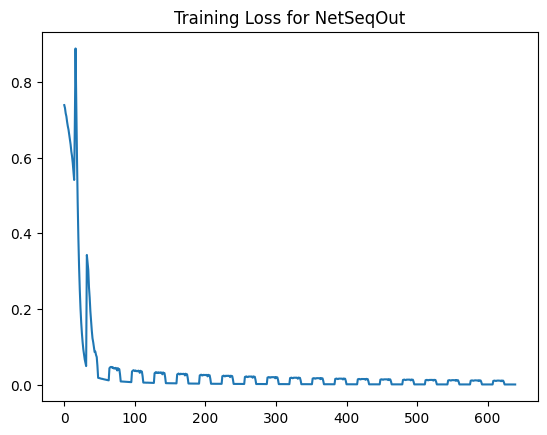

In [33]:
# === Train NetSeqOut ===
model = NetSeqOut()
model = model.to(device)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss(reduction='none')      #per-time-step loss

num_epochs = 20
batch_size = 64
e_losses = []

#move data to device
X = X.to(device)
Y_seq = Y_seq.to(device)
mask = mask.to(device)

for e in range(num_epochs):
    model.train()
    loss_batch = []

    for beg_i in range(0, X.size(0), batch_size):
        x_batch = X[beg_i:beg_i + batch_size, :]
        y_batch = Y_seq[beg_i:beg_i + batch_size, :]
        mask_batch = mask[beg_i:beg_i + batch_size, :]

        opt.zero_grad()
        logits_seq = model(x_batch)     #[B, T, 1]

        # compute per-time-step loss
        loss_seq = criterion(logits_seq, y_batch)       #[B, T, 1]
        loss_seq = loss_seq * mask_batch                #apply mask
        loss_seq = loss_seq.sum(1) / mask_batch.sum(1)  #average per sequence
        loss = loss_seq.mean(0)                         #mean over batch

        loss.backward()
        opt.step()
        loss_batch.append(loss.item())

    e_losses += loss_batch

#plot loss over epochs (tracks batch-level losses; NOT epoch-averaged)
plt.plot(e_losses)
plt.title('Training Loss for NetSeqOut')

In [34]:
# === Evaluate NetSeqOut ===
model.eval()

with torch.no_grad():
    torch.manual_seed(42)
    np.random.seed(42)

    logits_seq = model(X)                        #[B, T, 1]
    probs_seq = torch.sigmoid(logits_seq)        #convert logits to probs
    preds_seq = (probs_seq > 0.5).float()        #threshold at 0.5

#show a few examples
for i in range(3):
    print(f"\n=== Sample {i+1} ===")
    true_seq = Y_seq[i, :, 0][mask[i, :, 0] > 0]        #ground truth, unmasked
    pred_seq = preds_seq[i, :, 0][mask[i, :, 0] > 0]        #prediction, unmasked

    print("True :", true_seq.cpu().numpy().astype(int))
    print("Pred :", pred_seq.cpu().numpy().astype(int))


=== Sample 1 ===
True : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Pred : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

=== Sample 2 ===
True : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
Pred : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]

=== Sample 3 ===
True : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]
Pred : [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0]


# NetBCELoss()

In [35]:
# === Model 8: NetBCELoss (uses BCELoss instead of BCEWithLogitsLoss) ===
class NetBCELoss(Net):
    def __init__(self):
        super().__init__(feat_size=50)

    def forward(self, x):
        h1 = self.fc1(x)
        h1 = self.relu(h1)
        outputs, (final, _) = self.lstm(h1)

        if self.feat_representation == 'mean':
            outputs = self.dout(outputs)
            h = self.relu(self.fc2(outputs))
            h = h.mean(dim=1)
        elif self.feat_representation == 'last_state':
            if self.bidirectional:
                h_T_fwd = final[0]
                h_T_bwd = final[1]
                h = torch.cat([h_T_fwd, h_T_bwd], dim=-1)
            else:
                h = final[-1]
            h = self.relu(self.fc2(h))
            h = self.dout(h)

        logits = self.out(h)
        probs = self.out_act(logits)        #apply sigmoid here (final output)
        return probs

Text(0.5, 1.0, 'Training Loss for NetBCELoss')

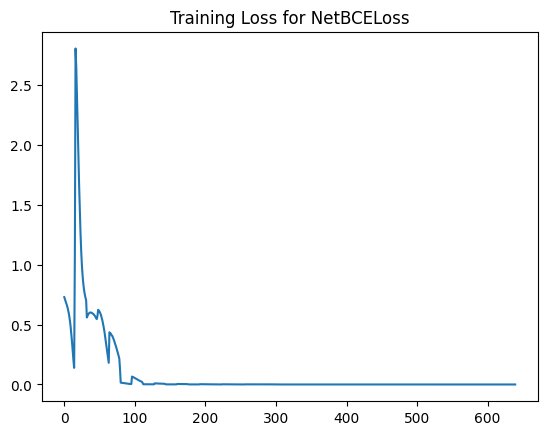

In [36]:
# === Train NetBCELoss ===
model = NetBCELoss()
model = model.to(device)

opt = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCELoss()        #new loss function

num_epochs = 20
batch_size = 64
e_losses = []

#move data to device
X = X.to(device)
Y = Y.to(device)

for e in range(num_epochs):
    model.train()
    loss_batch = []

    for beg_i in range(0, X.size(0), batch_size):
        x_batch = X[beg_i:beg_i + batch_size, :]
        y_batch = Y[beg_i:beg_i + batch_size, :]

        opt.zero_grad()

        #model now returns probabilities directly
        y_probs = model(x_batch)

        #compute loss
        loss = criterion(y_probs, y_batch)

        loss.backward()
        opt.step()

        loss_batch.append(loss.item())

    e_losses += loss_batch

#plot loss over epochs (tracks batch-level losses; NOT epoch-averaged)
plt.plot(e_losses)
plt.title('Training Loss for NetBCELoss')

In [37]:
# === Evaluate NetBCELoss ===
model.eval()

with torch.no_grad():
    torch.manual_seed(42)
    np.random.seed(42)

    #test on random sample (expected label 0)
    x_t = torch.randn(1, 48, 50).to(device)
    y_prob = model(x_t)
    print(f"Random sample (close 0): {y_prob.item():.4f}")

    #test on shifted sample (expected label 1)
    x_1_t = torch.randn(1, 48, 50).to(device) + 1.5
    y1_prob = model(x_1_t)
    print(f"Shifted sample (close 1): {y1_prob.item():.4f}")

Random sample (close 0): 0.0002
Shifted sample (close 1): 1.0000


# NetFeat128()

In [38]:
#create new data with bigger feature size and overwrite old
torch.manual_seed(42)
np.random.seed(42)

X1 = torch.randn(500, 5000, 128)
X2 = torch.randn(500, 5000, 128) + 1.5
X = torch.cat([X1, X2], dim=0)

Y1 = torch.zeros(500, 1)
Y2 = torch.ones(500, 1)
Y = torch.cat([Y1, Y2], dim=0)

#[N, F] instances, time, features
print(X.size())
#[N, 1] instances, label [0,1]
print(Y.size())

torch.Size([1000, 5000, 128])
torch.Size([1000, 1])


In [39]:
# === Model 9: NetFeat128 (use feat_size=128 instead of 100) ===
class NetFeat128(Net):
    def __init__(self):
        super().__init__(feat_size=128)

=== Architecture for NetFeat128 ===
NetFeat128(
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (relu): ReLU()
  (dout): Dropout(p=0.2, inplace=False)
  (lstm): LSTM(128, 100, batch_first=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (out): Linear(in_features=100, out_features=1, bias=True)
  (out_act): Sigmoid()
)


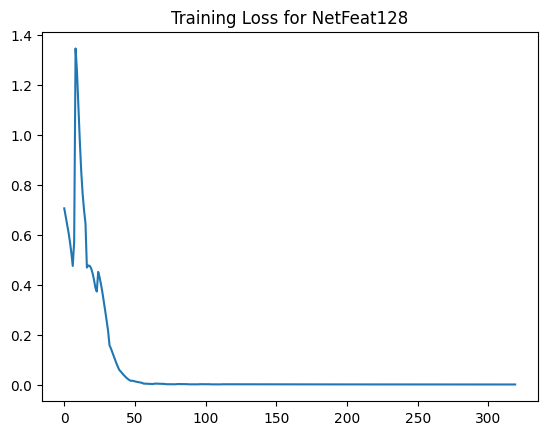

In [40]:
# === Train NetFeat128 ===
model_netfeat128 = train_model(NetFeat128, 'NetFeat128', X, Y, device=device)

In [41]:
# === Evaluate NetFeat128 ===
model_netfeat128.eval()

with torch.no_grad():
    #test on random sample (expected label 0)
    x_t = torch.randn(1, 5000, 128).to(device)
    _, y_prob = model_netfeat128(x_t)
    print(f"Random sample (close 0): {y_prob.item():.4f}")

    #test on shifted sample (expected label 1)
    x_1_t = torch.randn(1, 5000, 128).to(device) + 1.5
    _, y1_prob = model_netfeat128(x_1_t)
    print(f"Shifted sample (close 1): {y1_prob.item():.4f}")

Random sample (close 0): 0.0002
Shifted sample (close 1): 0.9999
